In [2]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalAE2 import MeanFieldVariationalAE
from Tools.NNtools import *

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Target density #

In [29]:
target_component = [
    torch.distributions.multivariate_normal.MultivariateNormal(torch.Tensor([-3,0]),0.01*torch.eye(2)),
    torch.distributions.multivariate_normal.MultivariateNormal(torch.Tensor([3,0]),torch.eye(2))
                   ]


In [30]:
p_target=torch.Tensor([0.5])
def logtarget(x,p=p_target):
    lp1=target_component[0].log_prob(x)+p.log()
    lp2=target_component[1].log_prob(x)+(1-p).log()
    lp=torch.cat([lp1,lp2])
    return lp.logsumexp(0).unsqueeze(-1)




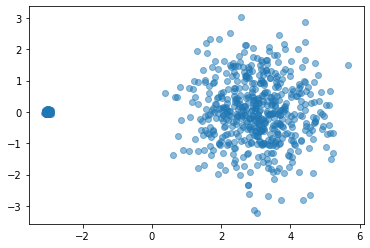

In [31]:
def sample():
    m = torch.multinomial(torch.cat([p_target,1-p_target]), 1, replacement=True)
    return target_component[int(m)].sample()

P=torch.Tensor(1000,2)
for i in range(1000):
    P[i,:]=sample()

#print(P[:,0])
plt.scatter(P[:,0],P[:,1],alpha=0.5)


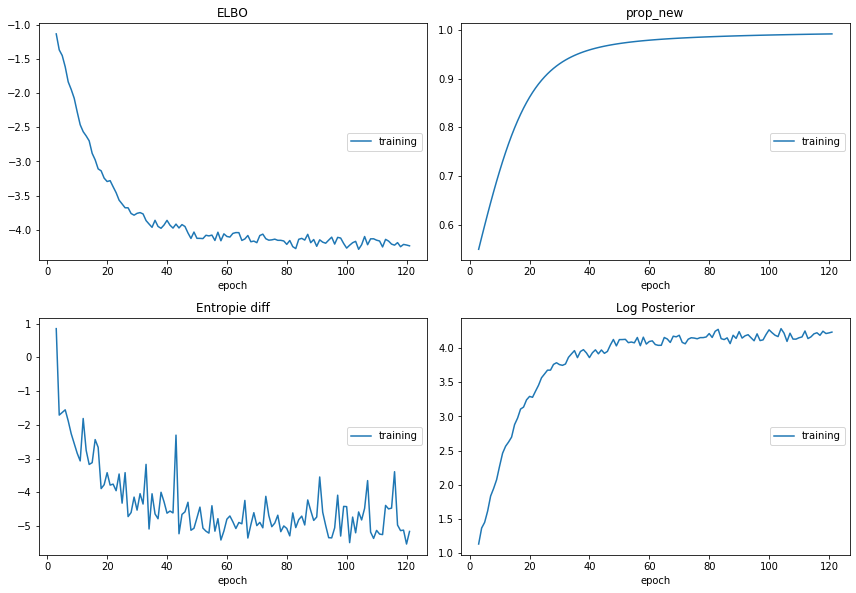

ELBO:
training   (min:   -4.288, max:   -0.738, cur:   -4.237)

prop_new:
training   (min:    0.500, max:    0.992, cur:    0.992)

Entropie diff:
training   (min:   -5.530, max:    0.848, cur:   -5.157)

Log Posterior:
training   (min:    0.738, max:    4.288, cur:    4.237)


KeyboardInterrupt: 

In [38]:

unbounded_prop_new = torch.tensor(0.0).requires_grad_(True)


optimizer = torch.optim.Adam([unbounded_prop_new], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

%matplotlib inline
liveloss = PlotLosses()

n_samples_VAR=100


for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    prop_new = torch.sigmoid(unbounded_prop_new)
    
    theta= target_component[0].sample((100,2))
    theta_= target_component[1].sample((100,2))
    LP=torch.Tensor(n_samples_VAR)
    LP_=torch.Tensor(n_samples_VAR)
    VE=torch.Tensor(n_samples_VAR)
    VE_=torch.Tensor(n_samples_VAR)
    for i in range(n_samples_VAR):
        LP[i]=logtarget(theta[i])
        LP_[i]=logtarget(theta_[i])
        VE=logtarget(theta[i],p=prop_new)
        VE_=logtarget(theta_[i],p=prop_new)
    
    ED=prop_new*VE.mean()+(1-prop_new)*VE_.mean()
    LPm=prop_new*LP.mean()+(1-prop_new)*LP_.mean()
    
    L = 0.*ED-LPm

    L.backward()

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
#    logs['learning rate'] = learning_rate
    logs['prop_new'] = prop_new.detach().clone().cpu().numpy()
    logs['Entropie diff'] = -ED.detach().clone().cpu().numpy()
    logs['Log Posterior'] = LPm.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
            liveloss.draw()

    optimizer.step()

    if learning_rate < 0.001:
        break

In [40]:
LP_.mean()

tensor(-1.5223)